# Load Data

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import json
import re

data_root = '../data/'
config_path = '../app_config.json'
config = json.load(open(config_path, 'r'))
data_dir = os.path.join(data_root, config['data_dir'])
data_index_pattern = re.compile(r'T(\d+).csv')

# data_files = (os.path.join(dirpath, filename)
#             for dirpath, dirnames, files in os.walk(data_dir)
#             for filename in files 
#             if data_index_pattern.search(filename) and int(data_index_pattern.search(filename).group(1)) in config['data_indices'])
data_files = [os.path.join(data_dir, filename) 
              for filename in os.listdir(data_dir) 
              if data_index_pattern.search(filename) and int(data_index_pattern.search(filename).group(1)) in config['data_indices']]

# dfs = []
# for i, file in enumerate(data_files):
#     # if i in [3]:
#     #     print(file)
#     #     continue
#     df = pd.read_csv(file, comment='#')
#     # print(df.info())
#     dfs.append(df)

# columns_set = set(dfs[0].columns)
# for i, df in enumerate(dfs):
#     if set(df.columns) != columns_set:
#         print('Columns do not match')
#         print('File:', data_files[i])
#         original_diff = columns_set - set(df.columns)
#         new_diff = set(df.columns) - columns_set
#         print('Original diff:', original_diff)
#         print('New diff:', new_diff)

dfs = [pd.read_csv(file, comment='#').rename(str.strip, axis="columns") for file in data_files]

df = pd.concat(dfs)

df.info()

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)



<class 'pandas.core.frame.DataFrame'>
Index: 349 entries, 0 to 73
Data columns (total 85 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   teamMemberCount                                              349 non-null    int64  
 1   femaleTeamMembersPercent                                     349 non-null    float64
 2   teamLeadGender                                               349 non-null    int64  
 3   teamDistribution                                             349 non-null    int64  
 4   teamMemberResponseCount                                      349 non-null    int64  
 5   meetingHoursTotal                                            349 non-null    float64
 6   meetingHoursAverage                                          349 non-null    float64
 7   meetingHoursStandardDeviation                                349 non-null    float64
 

In [9]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Train Test Split

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# split the data into train and test sets
train, test = train_test_split(df, test_size=0.2)

train_X = train.iloc[:, :-1]
train_y = train.iloc[:, -1]

test_X = test.iloc[:, :-1]
test_y = test.iloc[:, -1]

label_encoder = LabelEncoder()
label_encoder.fit(train_y)

train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)


# Scikit-learn based feature selection

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=25, n_jobs=-1)
# clf = LogisticRegression(max_iter=10000, n_jobs=-1)
selector = RFECV(clf, step=1, cv=10, scoring='accuracy', n_jobs=-1)

selector.fit(train_X, train_y)

print('Optimal number of features:', selector.n_features_)
print('Selected features:', train_X.columns[selector.support_])

Optimal number of features: 58
Selected features: Index(['teamMemberCount', 'teamMemberResponseCount', 'meetingHoursTotal',
       'meetingHoursAverage', 'meetingHoursStandardDeviation',
       'inPersonMeetingHoursTotal', 'inPersonMeetingHoursAverage',
       'inPersonMeetingHoursStandardDeviation',
       'nonCodingDeliverablesHoursTotal', 'nonCodingDeliverablesHoursAverage',
       'nonCodingDeliverablesHoursStandardDeviation',
       'codingDeliverablesHoursTotal',
       'codingDeliverablesHoursStandardDeviation', 'helpHoursTotal',
       'helpHoursAverage', 'helpHoursStandardDeviation',
       'averageResponsesByWeek', 'averageMeetingHoursTotalByWeek',
       'standardDeviationMeetingHoursTotalByWeek',
       'averageMeetingHoursAverageByWeek',
       'averageInPersonMeetingHoursTotalByWeek',
       'averageInPersonMeetingHoursAverageByWeek',
       'standardDeviationInPersonMeetingHoursAverageByWeek',
       'averageNonCodingDeliverablesHoursTotalByWeek',
       'standardDeviati

# plot feature selection results

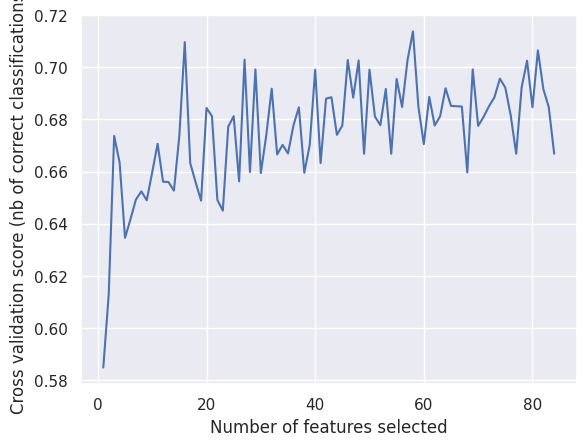

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.show()

# Feature Selection via GA

100%|██████████| 100/100 [05:48<00:00,  3.49s/it]


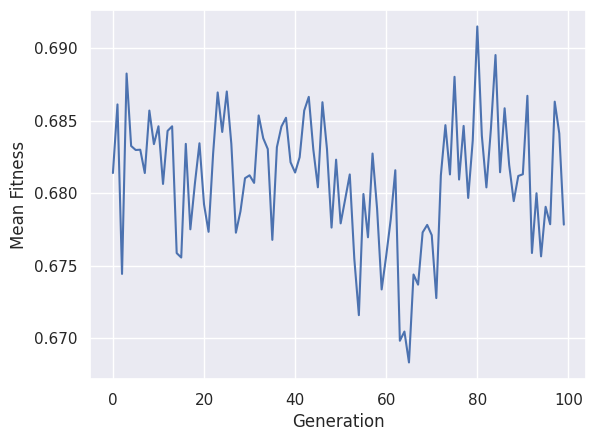

In [11]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm, trange


class GeneticAlgorithmFeatureSelector:
    def __init__(self, X, y, population_size = 20, n_generations = 100, crossover_rate = 0.8, mutation_rate = 0.1):
        self.population_size = population_size
        self.n_generations = n_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.fitness_history = None
        self.best_individual = None
        self.best_fitness = None
        
    def fit(self, X, y):
        self.fitness_history = []
        population = self._create_population(X)
        for i in trange(self.n_generations):
            fitnesses = self._calculate_fitness_for_population(X, y, population)
            
            this_best_individual, this_best_fitness = max(zip(population, fitnesses), key=lambda x: x[1])
            if self.best_individual is None or this_best_fitness > self.best_fitness:
                self.best_individual = this_best_individual
                self.best_fitness = this_best_fitness
                
            self.fitness_history.append(np.mean(fitnesses))
            
            population = self._evolve(population, fitnesses, self.population_size, self.crossover_rate, self.mutation_rate)
        
    def _create_population(self, X):
        population = []
        for i in trange(self.population_size):
            chromosome = np.random.choice([True, False], size=X.shape[1])
            population.append(chromosome)
        return np.array(population)
    
    def _calculate_fitness_for_population(self, X, y, population):
        fitnesses = [self._calculate_fitness(X, y, chromosome) for chromosome in population]
        return fitnesses
    
    def _calculate_fitness(self, X, y, chromosome):
        selected_columns = X.columns[chromosome]
        X_subset = X[selected_columns]
        
        rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
        accuracies = cross_val_score(rf, X_subset, y, cv=10, scoring='accuracy', n_jobs=-1)
        return np.mean(accuracies)
    
    def _evolve(self, population, fitnesses, population_size, crossover_rate, mutation_rate):
        new_population = []
        
        # elitism
        elites_size = int((1-crossover_rate) * population_size)
        elites_idx = np.random.choice(population_size, size=elites_size, replace=False, p = fitnesses/np.sum(fitnesses))
        # elites = np.random.choice(population, size=elites_size, p=fitnesses/np.sum(fitnesses), replace=False)
        elites = population[elites_idx]
        new_population.extend(elites)
        
        # crossover
        crossover_size = (population_size - elites_size)
        for i in range(crossover_size):
            parents_idx = np.random.choice(population_size, size=2, replace=False, p=fitnesses/np.sum(fitnesses))
            parent1, parent2 = population[parents_idx]
            child = self._crossover(parent1, parent2)
            new_population.append(child)
            
        # mutation
        new_population = [self._mutate(chromosome, mutation_rate) for chromosome in new_population]
        
        return np.array(new_population)
    
    def _crossover(self, parent1, parent2):
        crossover_point = np.random.randint(0, len(parent1))
        child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        return child
    
    def _mutate(self, chromosome, mutation_rate):
        for i in range(len(chromosome)):
            if np.random.rand() < mutation_rate:
                chromosome[i] = not chromosome[i]
        return chromosome
    
    def plot_fitness(self):
        plt.plot(self.fitness_history)
        plt.xlabel('Generation')
        plt.ylabel('Mean Fitness')
        plt.show()
        
        
ga = GeneticAlgorithmFeatureSelector(train_X, train_y, crossover_rate=0.8, mutation_rate=0.05, population_size=20, n_generations=100)
ga.fit(train_X, train_y)
ga.plot_fitness()
        
        
        
        
        
        
        
    

In [12]:
best_individual = ga.best_individual

# evaluate the best individual on the test set
selected_columns = test_X.columns[best_individual]
test_X_subset = test_X[selected_columns]

rf = RandomForestClassifier(n_estimators=25, n_jobs=-1)
rf.fit(train_X[selected_columns], train_y)
test_accuracy = rf.score(test_X[selected_columns], test_y)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.7285714285714285


# Feature Selection via SA

100%|██████████| 459/459 [03:07<00:00,  2.45it/s]


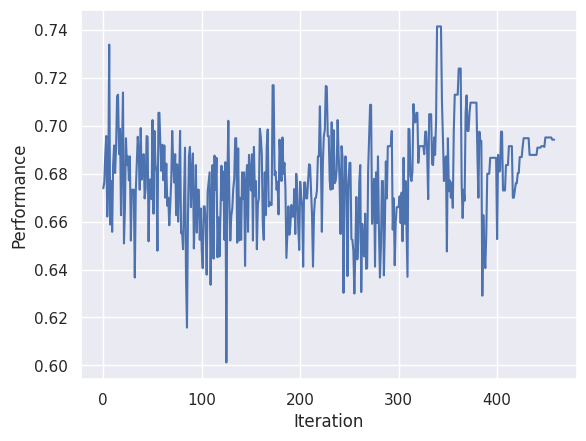

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange


class SimulatedAnnealingFeatureSelector:
    def __init__(self, T0 = 1, cooling_rate = 0.99, final_temperature = 0.01):
        self.T0 = T0
        self.cooling_rate = cooling_rate
        self.final_temperature = final_temperature
        self.best_individual = None
        self.best_performance = None
        self.performance_history = None
        
    def fit(self, X, y):
        self.performance_history = []
        temperature = self.T0
        current_individual = np.random.choice([True, False], size=X.shape[1])
        current_performance = self._calculate_performance(X, y, current_individual)
        
        expected_iterations = int(np.log(self.final_temperature/self.T0)/np.log(self.cooling_rate))
        
        for i in trange(expected_iterations + 1):
            if temperature < self.final_temperature:
                break
            new_individual = self._get_neighbor(current_individual)
            new_performance = self._calculate_performance(X, y, new_individual)
            
            if new_performance > current_performance or np.random.rand() < np.exp((new_performance - current_performance)/temperature):
                current_individual = new_individual
                current_performance = new_performance
                
            if self.best_individual is None or current_performance > self.best_performance:
                self.best_individual = current_individual
                self.best_performance = current_performance
                
            self.performance_history.append(current_performance)
            
            temperature *= self.cooling_rate
            
    def _get_neighbor(self, individual):
        new_individual = individual.copy()
        idx = np.random.randint(0, len(individual))
        new_individual[idx] = not new_individual[idx]
        return new_individual
    
    def _calculate_performance(self, X, y, individual):
        selected_columns = X.columns[individual]
        X_subset = X[selected_columns]
        
        rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
        accuracies = cross_val_score(rf, X_subset, y, cv=25, scoring='accuracy', n_jobs=-1)
        return np.mean(accuracies)
    
    def plot_performance(self):
        plt.plot(self.performance_history)
        plt.xlabel('Iteration')
        plt.ylabel('Performance')
        plt.show()
        
sa = SimulatedAnnealingFeatureSelector()
sa.fit(train_X, train_y)
sa.plot_performance()
        